In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus
import scikitplot as skplt

from IPython.display import Image
from itertools import cycle
from mpl_toolkits.mplot3d import Axes3D
from scipy import interp
from scipy.stats import randint as sp_randint
from sklearn import metrics, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, accuracy_score, confusion_matrix, classification_report, make_scorer, \
                            roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize, MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import export_graphviz
from sklearn.utils import resample

# Classification (with statistically assigned labels)

In [2]:
customer_profile = pd.read_csv('datasets/customer_indicators.csv', index_col=0)

## Computing score

In [3]:
ranges = [0.3, 0.7]
quantiles_m = customer_profile.quantile(q=ranges)
quantiles_m['RMonetary']

0.3      7.145611
0.7    127.860000
Name: RMonetary, dtype: float64

In [4]:
quantiles_d = customer_profile.quantile(q=ranges)
quantiles_d['Delta']

0.3      1.0
0.7    224.0
Name: Delta, dtype: float64

In [5]:
quantiles_r = customer_profile.quantile(q=ranges)
quantiles_r['Recency']

0.3     22.0
0.7    109.0
Name: Recency, dtype: float64

In [6]:
def ScoreMD(x, data, thresh, ranges):
    if x <= thresh[data][ranges[0]]:
        return 1
    elif x <= thresh[data][ranges[1]]:
        return 2
    else:
        return 3

def ScoreR(x, data, thresh, ranges):
    if x <= thresh[data][ranges[0]]:
        return 3
    elif x <= thresh[data][ranges[1]]:
        return 2
    else:
        return 1

In [7]:
customer_profile['MScore'] = customer_profile['RMonetary'].apply(ScoreMD, args=('RMonetary', quantiles_m, ranges))
customer_profile['DScore'] = customer_profile['Delta'].apply(ScoreMD, args=('Delta', quantiles_d, ranges))
customer_profile['RScore'] = customer_profile['Recency'].apply(ScoreR, args=('Recency', quantiles_r, ranges))
customer_profile['Score'] = (0.3 * customer_profile['MScore']
                           + 0.4 * customer_profile['DScore']
                           + 0.3 * customer_profile['RScore'])

In [8]:
ranges = [0.2, 0.7]
quantiles = customer_profile.quantile(q=ranges)

## Assigning labels

In [9]:
def Score(x, data, thresh, ranges):
    if x <= thresh[data][ranges[0]]:
        return 'Low'
    elif x <= thresh[data][ranges[1]]:
        return 'Medium'
    else:
        return 'High'

In [10]:
customer_labeled = customer_profile.copy()
customer_labeled['Label'] = customer_labeled['Score'].apply(Score, args=('Score', quantiles, ranges))
customer_labeled.head()

df_majority = customer_labeled[customer_labeled.Label == 'Medium']
df_minority = customer_labeled[customer_labeled.Label == 'Low']
df_middle   = customer_labeled[customer_labeled.Label == 'High']

customer_labeled.Label.value_counts()

Medium    2059
High      1227
Low       1036
Name: Label, dtype: int64

## Balancing classes

In [11]:
# Oversample minority classes.

df_minority_oversampled = resample(df_minority,
                                   replace=True,  # Sample with replacement.
                                   n_samples=len(df_majority))

df_middle_oversampled = resample(df_middle,
                                 replace=True,
                                 n_samples=len(df_majority))

# Combine majority class with oversampled minority classes.
df_oversampled = pd.concat([df_majority, df_minority_oversampled, df_middle_oversampled])
 
# Display new class counts.
customer_labeled = df_oversampled
customer_labeled.Label.value_counts()

Low       2059
High      2059
Medium    2059
Name: Label, dtype: int64

In [12]:
'''
# Undersampling.

df_majority_undersampled = resample(df_majority,
                                    replace=False,  # Sample without replacement.
                                    n_samples=len(df_minority))

df_middle_undersampled = resample(df_middle,
                                  replace=False,
                                  n_samples=len(df_minority))

df_undersampled = pd.concat([df_minority, df_majority_undersampled, df_middle_undersampled])

customer_labeled = df_undersampled
customer_labeled.Label.value_counts()
'''

'\n# Undersampling.\n\ndf_majority_undersampled = resample(df_majority,\n                                    replace=False,  # Sample without replacement.\n                                    n_samples=len(df_minority))\n\ndf_middle_undersampled = resample(df_middle,\n                                  replace=False,\n                                  n_samples=len(df_minority))\n\ndf_undersampled = pd.concat([df_minority, df_majority_undersampled, df_middle_undersampled])\n\ncustomer_labeled = df_undersampled\ncustomer_labeled.Label.value_counts()\n'

In [13]:
# Function to discretize the variables
# Input: the dataset and the list of variables' names to discretize

def discretize_data(dataset, variables):
    for variable in variables:
        mapping = {'High': 0, 'Medium': 1, 'Low': 2}

        # Add a new colum with the number representation of the variable
        dataset[variable + '_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [14]:
variables = ['Label']

# Discretize data, in this case only Label
customer_labeled = discretize_data(customer_labeled, variables)

# Drop the categorical variables since we don't need them anymore
customer_labeled = customer_labeled[['Recency', 'RFrequency', 'Label_num']]

label = customer_labeled.pop('Label_num')

scaler = MinMaxScaler()
customer_labeled = scaler.fit_transform(customer_labeled.values)

train_set, test_set, train_label, test_label = train_test_split(
                                                 customer_labeled, label, stratify=label, test_size=0.3)

In [15]:
train_label.head()

363     2
675     2
1436    2
2858    0
2956    0
Name: Label_num, dtype: int64

## Expected prediction

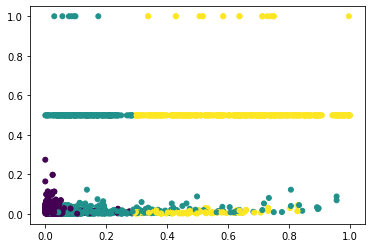

In [16]:
# x: Recency
# y: Frequency
plt.scatter(test_set[:, 0], test_set[:, 1], c=test_label.values, s=25)

## Decision Tree

In [17]:
# Decision tree

param_dist = {"max_depth": [2, 3, 5, 6, 7, 10, 12, None],
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "criterion": ["entropy", "gini"],
              "splitter": ["best", "random"]
              }

n_iter_search = 50

dec_t = tree.DecisionTreeClassifier()
grid_search = RandomizedSearchCV(dec_t, param_distributions=param_dist,
                                 n_iter=n_iter_search,
                                 n_jobs=-1,
                                 scoring=make_scorer(accuracy_score)).fit(train_set, train_label)

In [18]:
print('Best setting parameters ', grid_search.best_params_)

Best setting parameters  {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 30, 'min_samples_split': 21, 'splitter': 'best'}


In [19]:
# Decision tree

dec_t = tree.DecisionTreeClassifier(**grid_search.best_params_).fit(train_set, train_label)

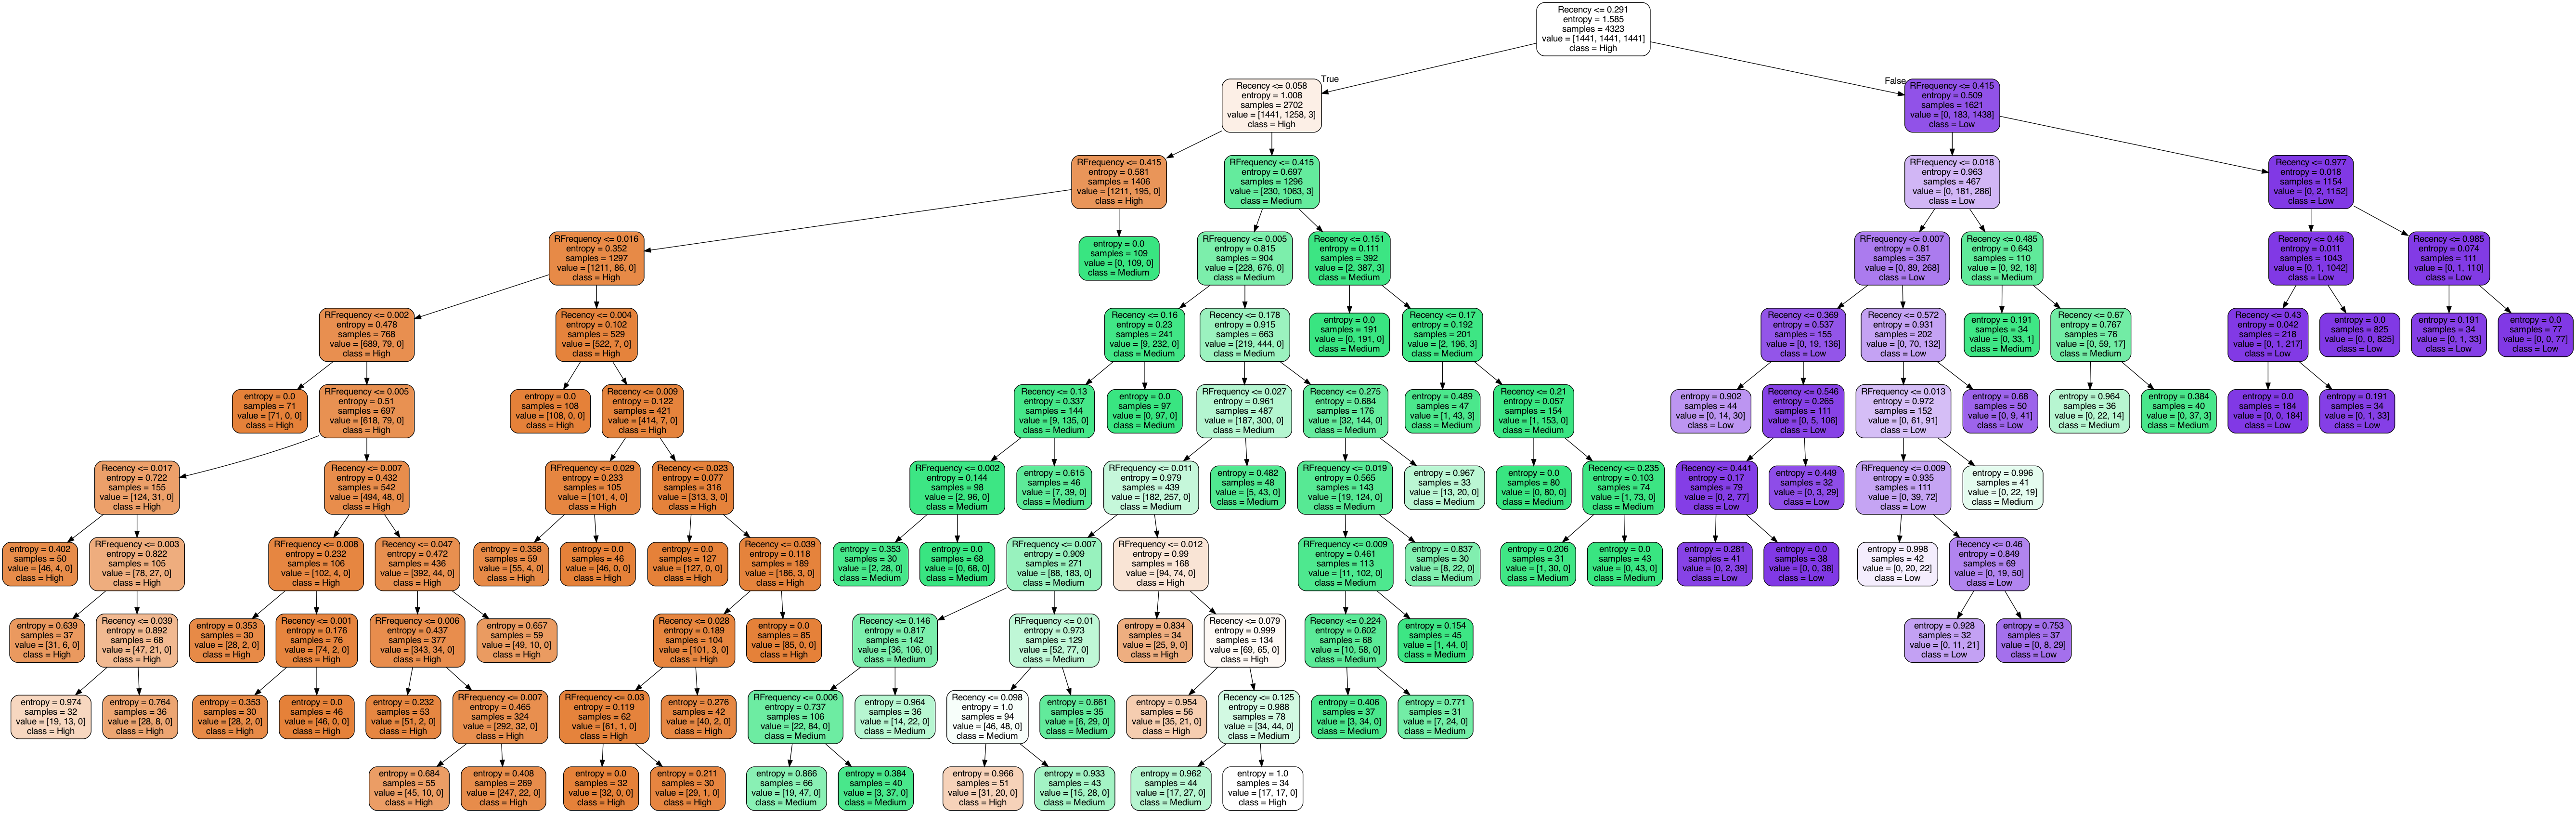

In [20]:
# Show decision tree

dot_data = tree.export_graphviz(dec_t, out_file=None,
                                feature_names=['Recency', 'RFrequency'],
                                class_names=['High', 'Medium', 'Low'],
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [21]:
def predict(model, train_set, test_set):
    train_pred = model.predict(train_set)
    test_pred = model.predict(test_set)
    return train_pred, test_pred

In [22]:
train_pred_dt, test_pred_dt = predict(dec_t, train_set, test_set)

### Evaluation of the decision tree: compute accuracy, precision, recall, confusion matrix

In [23]:
def print_scores(train_label, train_pred, test_label, test_pred, target_names_):
    print('Accuracy train set:', metrics.accuracy_score(train_label, train_pred))
    print('Accuracy test set: ', metrics.accuracy_score(test_label, test_pred))
    print()
    print('F1 score train set:', metrics.f1_score(train_label, train_pred, average='weighted'))
    print('F1 score test set: ', metrics.f1_score(test_label, test_pred, average='weighted'))
    print('Train:')
    print(classification_report(train_label, train_pred, target_names=target_names_))
    print('-' * 53)
    print('Test:')
    print(classification_report(test_label, test_pred, target_names=target_names_))

In [24]:
print_scores(train_label, train_pred_dt, test_label, test_pred_dt, ['High', 'Medium', 'Low'])

Accuracy train set: 0.9111727966689799
Accuracy test set:  0.8969795037756203

F1 score train set: 0.9106925740182737
F1 score test set:  0.8965218410568562
Train:
              precision    recall  f1-score   support

        High       0.90      0.92      0.91      1441
      Medium       0.88      0.85      0.86      1441
         Low       0.95      0.97      0.96      1441

    accuracy                           0.91      4323
   macro avg       0.91      0.91      0.91      4323
weighted avg       0.91      0.91      0.91      4323

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.86      0.92      0.89       618
      Medium       0.87      0.82      0.84       618
         Low       0.96      0.95      0.96       618

    accuracy                           0.90      1854
   macro avg       0.90      0.90      0.90      1854
weighted avg       0.90      0.90      0.90      1854



In [25]:
# compute confusion matrix

print('Train:')
print(confusion_matrix(train_label, train_pred_dt))
print('-' * 18)
print('Test:')
print(confusion_matrix(test_label, test_pred_dt))

Train:
[[1319  122    0]
 [ 153 1219   69]
 [   0   40 1401]]
------------------
Test:
[[569  49   0]
 [ 89 504  25]
 [  0  28 590]]


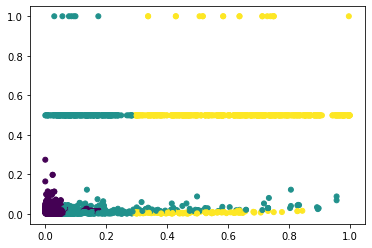

In [26]:
# x: Recency
# y: Frequency
plt.scatter(test_set[:, 0], test_set[:, 1], c=test_pred_dt, s=25)

## SVM

In [27]:
params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
          'gamma' : ['scale', 1e-2, 1e-3, 1e-4, 1e-5],
          'C'     : [0.001, 0.10, 0.1, 0.5, 1, 10]
         }

grid_search = RandomizedSearchCV(SVC(), params,
                                 n_jobs=-1,
                                 n_iter=n_iter_search,
                                 scoring=make_scorer(accuracy_score)).fit(train_set, train_label)

print(grid_search.best_params_)


# Binarize the output
test_label_binarized = label_binarize(test_label, classes=[0, 1, 2])
train_label_binarized = label_binarize(train_label, classes=[0, 1, 2])

svm = SVC(**grid_search.best_params_).fit(train_set, train_label)
svm_binarize = OneVsRestClassifier(svm).fit(train_set, train_label_binarized)

#pd.concat([pd.DataFrame(grid_search.cv_results_["params"]), pd.DataFrame(grid_search.cv_results_["mean_test_score"],
#                                                                         columns=["Accuracy"])], axis=1)

{'kernel': 'linear', 'gamma': 'scale', 'C': 10}


In [28]:
# Predictions

train_pred_svm_binarized, test_pred_svm_binarized = predict(svm_binarize, train_set, test_set)
train_pred_svm, test_pred_svm = predict(svm, train_set, test_set)

In [29]:
# Compute the performance of the model

print_scores(train_label, train_pred_svm, test_label, test_pred_svm, ['High', 'Medium', 'Low'])

Accuracy train set: 0.8538052278510294
Accuracy test set:  0.8505933117583603

F1 score train set: 0.8506547912126889
F1 score test set:  0.8472647950239206
Train:
              precision    recall  f1-score   support

        High       0.82      0.91      0.86      1441
      Medium       0.83      0.70      0.76      1441
         Low       0.91      0.95      0.93      1441

    accuracy                           0.85      4323
   macro avg       0.85      0.85      0.85      4323
weighted avg       0.85      0.85      0.85      4323

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.79      0.93      0.85       618
      Medium       0.84      0.68      0.75       618
         Low       0.93      0.94      0.94       618

    accuracy                           0.85      1854
   macro avg       0.85      0.85      0.85      1854
weighted avg       0.85      0.85      0.85      1854



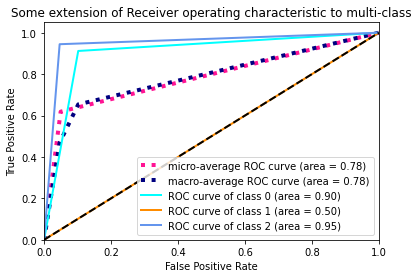

In [30]:
n_classes = 3
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(train_label_binarized[:, i], train_pred_svm_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(train_label_binarized.ravel(), train_pred_svm_binarized.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

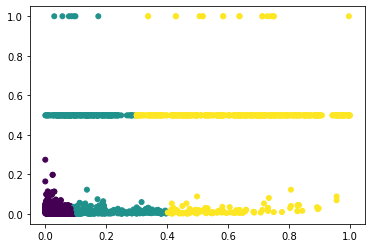

In [31]:
# x: Frequency
# y: Max items
plt.scatter(test_set[:, 0], test_set[:, 1], c= test_pred_svm, s=25)

## KNN

In [32]:
params = {'n_neighbors': [2, 4, 6, 8, 10, 15, 20, 25, 50],
          'algorithm': ['ball_tree', 'kd_tree']
         }

grid_search = GridSearchCV(KNeighborsClassifier(), params,
                           n_jobs=-1,
                           scoring=make_scorer(accuracy_score)).fit(train_set, train_label)

print(grid_search.best_params_)


knn = KNeighborsClassifier(**grid_search.best_params_).fit(train_set, train_label)

{'algorithm': 'ball_tree', 'n_neighbors': 8}


In [33]:
train_pred_knn, test_pred_knn = predict(knn, train_set, test_set)

In [34]:
print_scores(train_label, train_pred_knn, test_label, test_pred_knn, ['High', 'Medium', 'Low'])

Accuracy train set: 0.9141799676150821
Accuracy test set:  0.8824163969795038

F1 score train set: 0.9133868077001164
F1 score test set:  0.8813321134206513
Train:
              precision    recall  f1-score   support

        High       0.89      0.94      0.91      1441
      Medium       0.90      0.83      0.87      1441
         Low       0.95      0.97      0.96      1441

    accuracy                           0.91      4323
   macro avg       0.91      0.91      0.91      4323
weighted avg       0.91      0.91      0.91      4323

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.84      0.93      0.88       618
      Medium       0.86      0.77      0.81       618
         Low       0.95      0.94      0.95       618

    accuracy                           0.88      1854
   macro avg       0.88      0.88      0.88      1854
weighted avg       0.88      0.88      0.88      1854



## Classification with Random Forest

In [35]:
# To find the best set of parameter setting, we can run a grid search.

param_dist = {"max_depth": [2, 3, 5, 6, 7, 10, 12, None],
              "max_features": sp_randint(1, len(train_set[0]) + 1),
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight": ['balanced', None, {0: 0.25, 1: 0.50, 2: 0.25}]}

n_iter_search = 50

clf = RandomForestClassifier()

grid_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                            n_iter=n_iter_search,
                            n_jobs=-1,
                            scoring=make_scorer(accuracy_score)).fit(train_set, train_label)

In [36]:
print('Best setting parameters ', grid_search.best_params_)

Best setting parameters  {'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 1, 'min_samples_leaf': 30, 'min_samples_split': 47}


In [37]:
rf = RandomForestClassifier(**grid_search.best_params_).fit(train_set, train_label)

In [38]:
train_pred_rf, test_pred_rf = predict(rf, train_set, test_set)

In [39]:
print_scores(train_label, train_pred_rf, test_label, test_pred_rf, ['High', 'Medium', 'Low'])

Accuracy train set: 0.9137173259310664
Accuracy test set:  0.8959007551240561

F1 score train set: 0.9134314875922714
F1 score test set:  0.8959157530982477
Train:
              precision    recall  f1-score   support

        High       0.92      0.89      0.91      1441
      Medium       0.87      0.87      0.87      1441
         Low       0.95      0.98      0.96      1441

    accuracy                           0.91      4323
   macro avg       0.91      0.91      0.91      4323
weighted avg       0.91      0.91      0.91      4323

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.89      0.88      0.89       618
      Medium       0.84      0.85      0.84       618
         Low       0.96      0.96      0.96       618

    accuracy                           0.90      1854
   macro avg       0.90      0.90      0.90      1854
weighted avg       0.90      0.90      0.90      1854



## Neural networks

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.python.keras.utils.np_utils import to_categorical

model = Sequential()
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [41]:
train_label_nn = to_categorical(train_label, 3)
test_label_nn = to_categorical(test_label, 3)

In [42]:
history = model.fit(train_set, train_label_nn,
                    epochs=50,
                    batch_size=256,
                    validation_split=0.3)

Epoch 1/50
12/12 [==============================] - 1s 60ms/step - loss: 1.0342 - accuracy: 0.4812 - val_loss: 1.0273 - val_accuracy: 0.4965
Epoch 2/50
12/12 [==============================] - 0s 9ms/step - loss: 1.0150 - accuracy: 0.6210 - val_loss: 1.0066 - val_accuracy: 0.6476
Epoch 3/50
12/12 [==============================] - 0s 8ms/step - loss: 0.9902 - accuracy: 0.6794 - val_loss: 0.9818 - val_accuracy: 0.6862
Epoch 4/50
12/12 [==============================] - 0s 9ms/step - loss: 0.9639 - accuracy: 0.7108 - val_loss: 0.9520 - val_accuracy: 0.7032
Epoch 5/50
12/12 [==============================] - 0s 7ms/step - loss: 0.9343 - accuracy: 0.7188 - val_loss: 0.9166 - val_accuracy: 0.7247
Epoch 6/50
12/12 [==============================] - 0s 10ms/step - loss: 0.8999 - accuracy: 0.7419 - val_loss: 0.8792 - val_accuracy: 0.7564
Epoch 7/50
12/12 [==============================] - 0s 10ms/step - loss: 0.8629 - accuracy: 0.7459 - val_loss: 0.8402 - val_accuracy: 0.7818
Epoch 8/50
12/12 

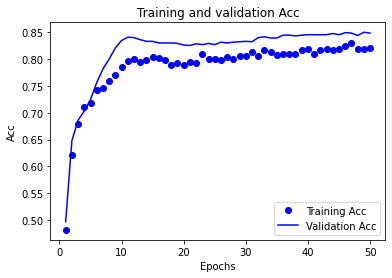

In [43]:
lw = 2
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [44]:
train_pred_nn = np.argmax(model.predict(train_set), axis=-1)
test_pred_nn = np.argmax(model.predict(test_set), axis=-1)

In [45]:
print_scores(train_label, train_pred_nn, test_label, test_pred_nn, ['High', 'Medium', 'Low'])

Accuracy train set: 0.8480222068008327
Accuracy test set:  0.8468176914778857

F1 score train set: 0.8435905706369661
F1 score test set:  0.8421555546355595
Train:
              precision    recall  f1-score   support

        High       0.81      0.92      0.86      1441
      Medium       0.84      0.67      0.75      1441
         Low       0.90      0.95      0.92      1441

    accuracy                           0.85      4323
   macro avg       0.85      0.85      0.84      4323
weighted avg       0.85      0.85      0.84      4323

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.78      0.94      0.85       618
      Medium       0.85      0.66      0.74       618
         Low       0.92      0.94      0.93       618

    accuracy                           0.85      1854
   macro avg       0.85      0.85      0.84      1854
weighted avg       0.85      0.85      0.84      1854



## Classification with Naive Bayes

In [46]:
gnb = GaussianNB().fit(train_set, train_label)

train_pred_gnb, test_pred_gnb = predict(gnb, train_set, test_set)

In [47]:
print_scores(train_label, train_pred_gnb, test_label, test_pred_gnb, ['High', 'Medium', 'Low'])

Accuracy train set: 0.7987508674531575
Accuracy test set:  0.785329018338727

F1 score train set: 0.793855707132988
F1 score test set:  0.7793557974688664
Train:
              precision    recall  f1-score   support

        High       0.74      0.95      0.83      1441
      Medium       0.75      0.59      0.66      1441
         Low       0.93      0.85      0.89      1441

    accuracy                           0.80      4323
   macro avg       0.80      0.80      0.79      4323
weighted avg       0.80      0.80      0.79      4323

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.71      0.96      0.82       618
      Medium       0.73      0.56      0.63       618
         Low       0.94      0.84      0.89       618

    accuracy                           0.79      1854
   macro avg       0.80      0.79      0.78      1854
weighted avg       0.80      0.79      0.78      1854



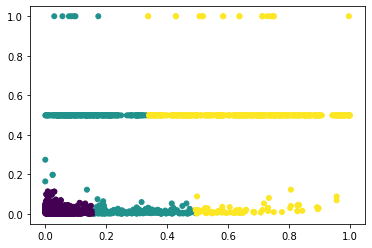

In [48]:
# x: Recency
# y: Frequency
plt.scatter(test_set[:, 0], test_set[:, 1], c= test_pred_gnb, s=25)